In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [2]:
raw_data = pd.read_csv('VDT2022_Telco_Customer_Churn_Dataset.csv')
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
raw_data.shape

(7043, 21)

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Hãy làm sạch dữ liệu 1 chút
- `SeniorCitizen` sẽ là object vì feature này cho biết khách hàng thuộc 2 nhóm đối tượng: lớn tuổi (>= 62t) và không
- `TotalCharges` sẽ là float64 thì feature này cho biết tổng doanh thu do 1 khách hàng tạo ra từ trước đến giờ

In [5]:
raw_data['SeniorCitizen'] = raw_data['SeniorCitizen'].astype('object')
raw_data['TotalCharges'] = pd.to_numeric(raw_data['TotalCharges'], errors='coerce')

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Có 1 số ít dữ liệu bị thiếu ở feature `TotalCharges` sau khi đã được làm sạch. Hãy tìm hiểu 1 chút

In [7]:
raw_data['TotalCharges'].isna().sum()

11

In [8]:
raw_data[np.isnan(raw_data['TotalCharges'])].head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No


Có thể thấy mặc dù thông tin của khách hàng đều có đầy đủ giá trị ở `tenure` và `MonthlyCharges` vì 1 số lý do lại thiếu đi giá trị ở `TotalCharges`. <br>
Chúng ta sẽ dễ dàng điền vào những giá trị trống này bằng cách lấy giá trị ở `tenure` * `MonthlyCharges`

In [9]:
raw_data['TotalCharges'].fillna(raw_data['tenure'] * raw_data['MonthlyCharges'], inplace=True)

In [10]:
raw_data.info()
raw_data.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

In [11]:
raw_data.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


- 1 nửa lượng khách hàng đăng kí dịch vụ hơn 29 tháng - hơn 2 năm
- Trung bình doanh thu theo tháng này của công ty rơi vào khoảng `$65`/khách hàng
- Trung bình tổng doanh thu của công ty rơi vào khoảng `$2280`/khách hàng

In [12]:
raw_data.groupby('Churn').describe().T

Churn                          No          Yes
tenure         count  5174.000000  1869.000000
               mean     37.569965    17.979133
               std      24.113777    19.531123
               min       0.000000     1.000000
               25%      15.000000     2.000000
               50%      38.000000    10.000000
               75%      61.000000    29.000000
               max      72.000000    72.000000
MonthlyCharges count  5174.000000  1869.000000
               mean     61.265124    74.441332
               std      31.092648    24.666053
               min      18.250000    18.850000
               25%      25.100000    56.150000
               50%      64.425000    79.650000
               75%      88.400000    94.200000
               max     118.750000   118.350000
TotalCharges   count  5174.000000  1869.000000
               mean   2549.911442  1531.796094
               std    2329.954215  1890.822994
               min       0.000000    18.850000
               25%     572.900000   134.500000
               50%    1679.525000   703.550000
               75%    4262.850000  2331.300000
               max    8672.450000  8684.800000

- Dễ dàng thấy được trung bình số tháng đăng kí của những người ở lại cao hơn những người rời đi
- Trung bình `MonthlyCharges` của những người rời đi lại cao hơn những người ở lại, điều này cần tìm hiểu kĩ để có thể đưa ra kết luận

In [13]:
raw_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

# EDA

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

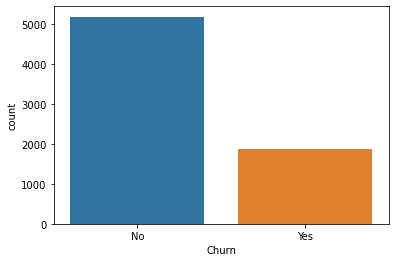

In [14]:
sns.countplot(x='Churn', data=raw_data)

raw_data['Churn'].value_counts(normalize=True)

In [15]:
print('Tổng doanh thu bị mất mỗi tháng dựa trên lượng khách hàng rời đi: $' + str(raw_data[raw_data['Churn'] == 'Yes']['MonthlyCharges'].sum()))

Tổng doanh thu bị mất mỗi tháng dựa trên lượng khách hàng rời đi: $139130.85


- `26.54%` người dùng rời dịch vụ so với tháng trước
- Công ty bị sụt giảm `$140k` mỗi tháng, chiếm `30.5%` doanh thu mỗi tháng

#### Hãy tìm hiểu các feature của dữ liệu

## `gender`

<AxesSubplot:xlabel='gender', ylabel='count'>

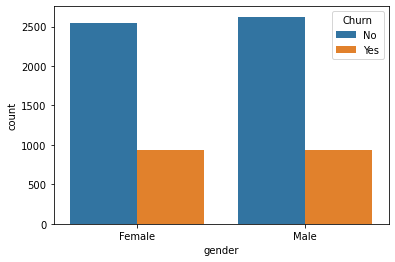

In [16]:
sns.countplot(x='gender', hue='Churn', data=raw_data)

In [17]:
raw_data.groupby('gender')[['MonthlyCharges', 'TotalCharges']].mean()

,MonthlyCharges,TotalCharges
gender,,
Female,65.204243,2279.918062
Male,64.327482,2279.554008


- Giới tính của người đăng kí không làm ảnh hưởng đến việc họ rời dịch vụ hay không 
- Giới tính của người đăng kí không gây ảnh hưởng đến doanh thu của công ty

## `SeniorCitizen`

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

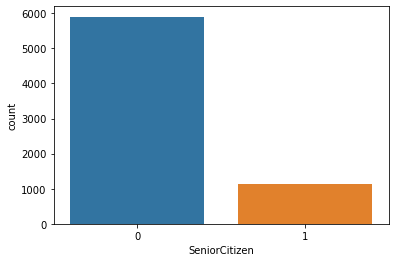

In [18]:
sns.countplot(x='SeniorCitizen', data=raw_data)

raw_data['SeniorCitizen'].value_counts()

Phần lớn những người dùng dịch vụ tháng này đều không phải là Senior Citizen, chiếm `83.79%`

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

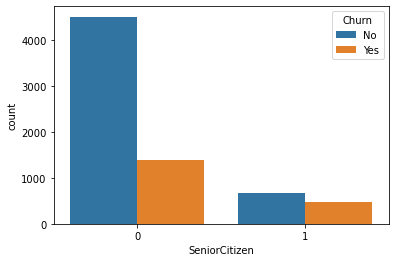

In [19]:
sns.countplot(x='SeniorCitizen', hue='Churn', data=raw_data)

Text(0.5, 1.0, 'SeniorCitizen vs TotalCharges')

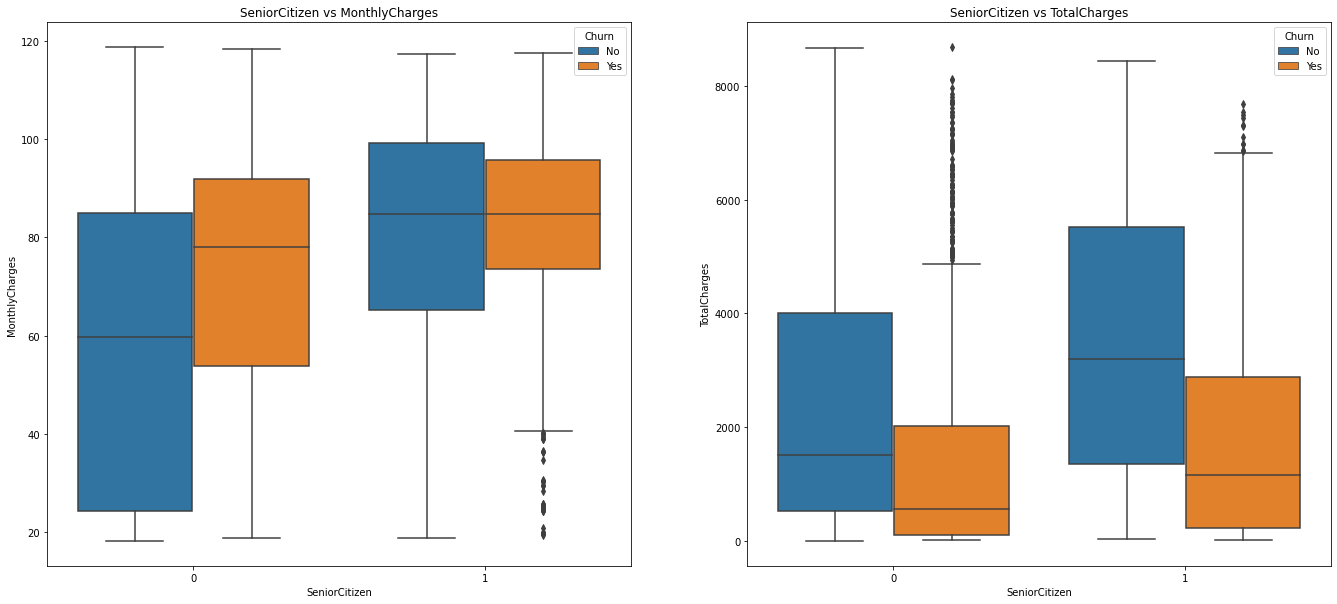

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(23,10))

sns.boxplot(x='SeniorCitizen', y='MonthlyCharges', hue='Churn', data=raw_data, ax=ax[0])
sns.boxplot(x='SeniorCitizen', y='TotalCharges', hue='Churn', data=raw_data, ax=ax[1])

ax[0].set_title('SeniorCitizen vs MonthlyCharges')
ax[1].set_title('SeniorCitizen vs TotalCharges')

- Chúng ta có thể thấy những `SeniorCitizen` chi nhiều tiền hơn cho dịch vụ của công ty. Họ có trung bình `MonthlyCharges` và `TotalCharges` cao hơn. Nhưng họ chỉ chiếm `16.21%` lượng người đăng kí và có tỉ lệ bỏ dịch vụ lên tới `41.68%` vào tháng sau
- Tổng doanh thu của công ty vẫn đến chủ yếu từ những Non Senior Citizen vì họ chiếm `83.79%` lượng người đăng kí và có `23.61%` tỉ lệ bỏ dịch vụ vào tháng sau <br> <br>
<b>Tỉ lệ bỏ dịch vụ của Senior Citizen là rất đáng chú ý</b>

## `Partner`

<AxesSubplot:xlabel='Partner', ylabel='count'>

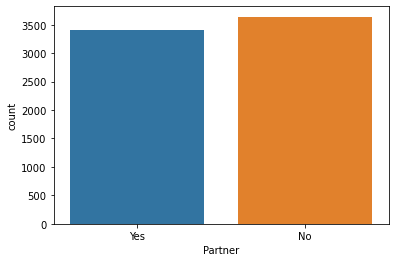

In [21]:
sns.countplot(x='Partner', data=raw_data)

<AxesSubplot:xlabel='Partner', ylabel='count'>

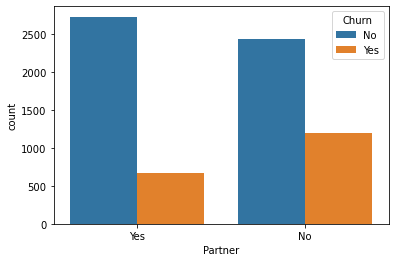

In [22]:
sns.countplot(x='Partner', hue='Churn', data=raw_data)

,tenure,MonthlyCharges,TotalCharges
Partner,,,
No,23.357869,61.945001,1584.089810
Yes,42.017637,67.776264,3024.249765


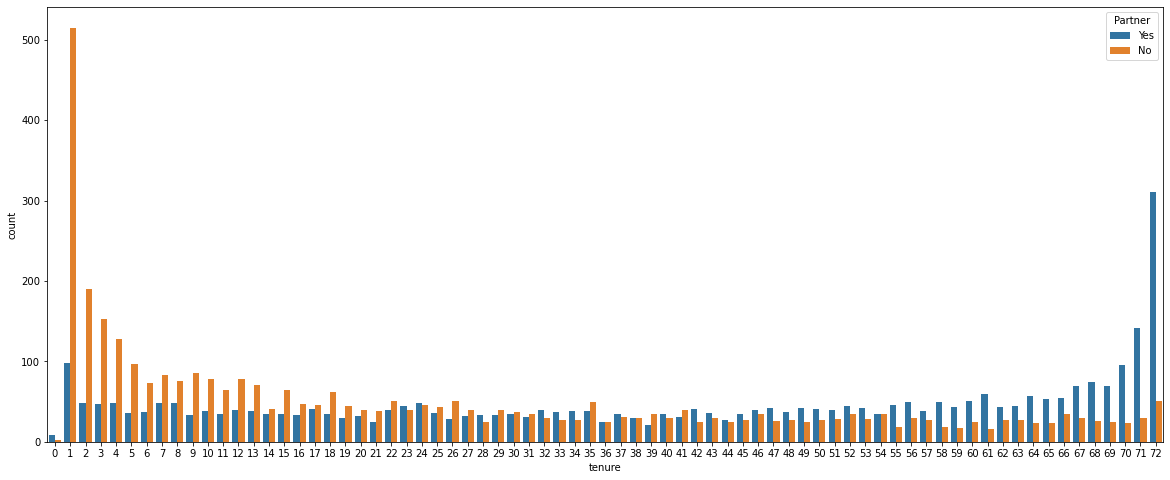

In [23]:
plt.figure(figsize=(20,8))
sns.countplot(x='tenure', hue='Partner', data=raw_data)

raw_data.groupby('Partner')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

- Có thể thấy được nhóm người có `Partner` ở lại với công ty lâu hơn
- Tỉ lệ rời dịch vụ của những người không có `Partner` cao hơn những người có `Partner`
- Trung bình doanh thu theo tháng công ty thu được từ những người có `Partner` so với những người không có `Partner` là gần như nhau
- Nhưng điều đáng chú ý là những người có `Partner` gắn bó với dịch vụ lâu hơn rất nhiều. Vì vậy tổng doanh thu thu được từ những người có `Partner` sẽ cao hơn

## `Dependents`

<AxesSubplot:xlabel='Dependents', ylabel='count'>

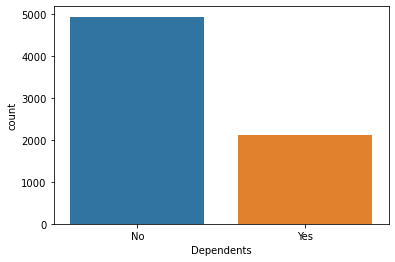

In [24]:
sns.countplot(x='Dependents', data=raw_data)

`70.04%` những người đăng kí không có người phụ thuộc

<AxesSubplot:xlabel='Partner', ylabel='count'>

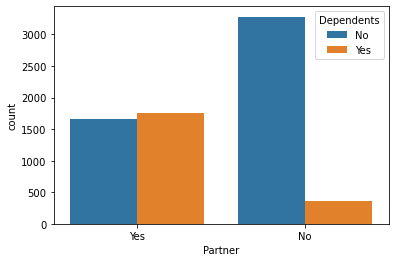

In [25]:
sns.countplot(x='Partner', hue='Dependents', data=raw_data)

Dễ dàng thấy được những người có `Partner` sẽ có nhiều người phụ thuộc (con cái) hơn những người độc thân

<AxesSubplot:xlabel='Dependents', ylabel='count'>

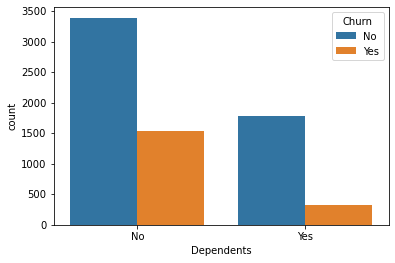

In [26]:
sns.countplot(x='Dependents', hue='Churn', data=raw_data)

Có thể thấy được tỉ lệ rời dịch vụ của những người có người phụ thuộc thấp hơn nhiều so với những người không có người phụ thuộc (`15.45%` vs `31.28%`)

,tenure,MonthlyCharges,TotalCharges
Dependents,,,
No,29.806000,67.002808,2187.709254
Yes,38.368246,59.522156,2494.881019


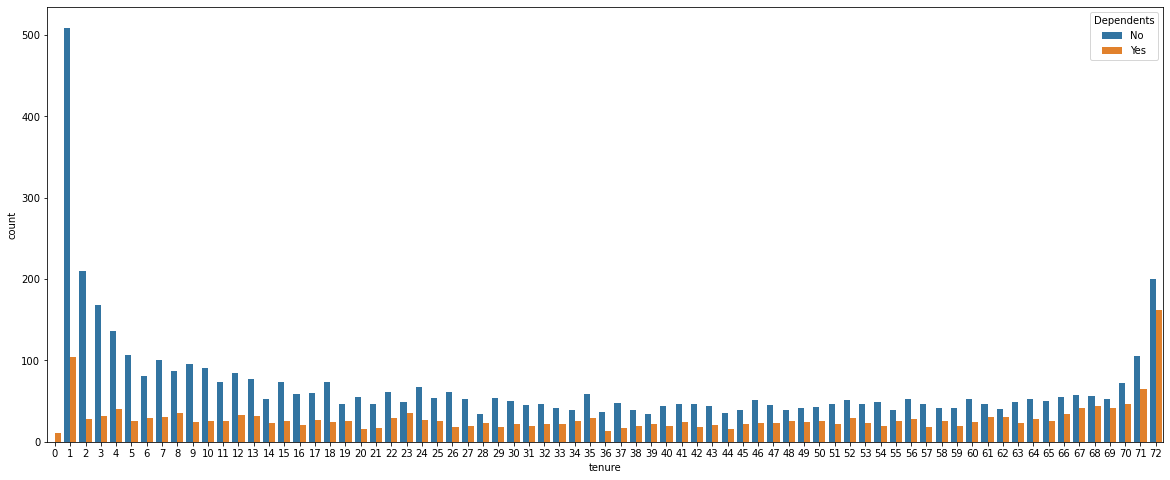

In [27]:
plt.figure(figsize=(20,8))
sns.countplot(x='tenure', hue='Dependents', data=raw_data)

raw_data.groupby('Dependents')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

- Có thể thấy được thời gian đăng kí càng lâu, tỉ lệ của nhóm người có người phụ thuộc càng tăng
- Mặc dù chỉ chiếm khoảng `30%` lượng người đăng kí, nhưng nhóm người có `Dependents` trung bình chi nhiều tiền hơn cho dịch vụ và cung cấp doanh thu nhiều hơn cho công ty

## `tenure`

In [28]:
raw_data.describe()['tenure']

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

<AxesSubplot:xlabel='Churn', ylabel='count'>

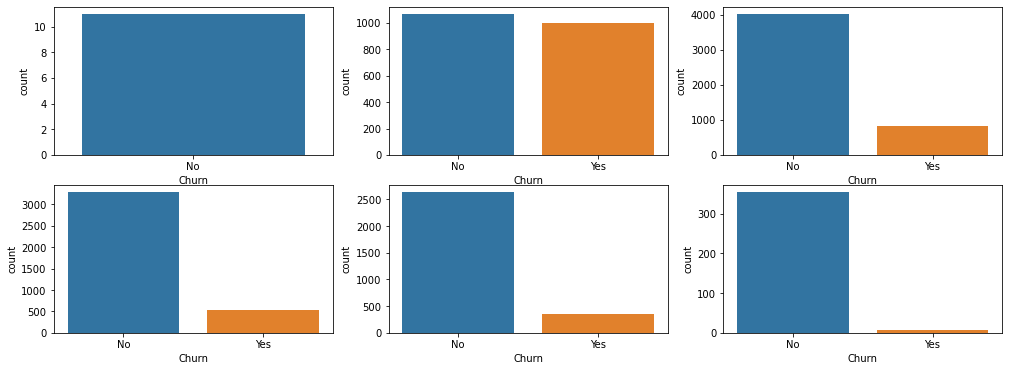

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(17,6))

sns.countplot(x='Churn', data=raw_data[raw_data['tenure'] == 0], ax=ax[0][0])
sns.countplot(x='Churn', data=raw_data[raw_data['tenure'] < 12], ax=ax[0][1])
sns.countplot(x='Churn', data=raw_data[raw_data['tenure'] > 12], ax=ax[0][2])
sns.countplot(x='Churn', data=raw_data[raw_data['tenure'] > 24], ax=ax[1][0])
sns.countplot(x='Churn', data=raw_data[raw_data['tenure'] > 36], ax=ax[1][1])
sns.countplot(x='Churn', data=raw_data[raw_data['tenure'] == 72], ax=ax[1][2])

<AxesSubplot:xlabel='Churn', ylabel='tenure'>

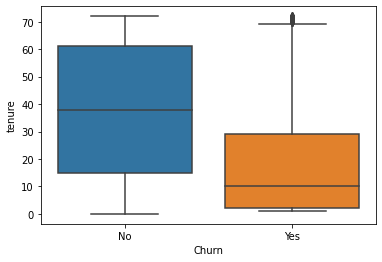

In [30]:
sns.boxplot(x='Churn', y='tenure', data=raw_data)

- `100%` những người dùng dịch vụ tháng đầu đều đăng kí tiếp vào tháng sau
- Người dùng mới có xu hướng bỏ dịch vụ
- Tỉ lệ bỏ dịch vụ của những người đăng kí dưới 1 năm là rất cao (gần `50%`)
- Thời gian đăng kí càng lâu thì tỉ lệ người dùng rời đi vào tháng sau càng giảm mạnh
- Người dùng đăng kí càng lâu thì càng chi nhiều tiền hơn cho dịch vụ 

In [31]:
def analyze(col):
    print(raw_data[col].value_counts(normalize=True))
    
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.countplot(x=col, data=raw_data, ax=ax[0])
    sns.countplot(x=col, hue='Churn', data=raw_data, ax=ax[1])

## `PhoneService`

Yes    0.903166
No     0.096834
Name: PhoneService, dtype: float64


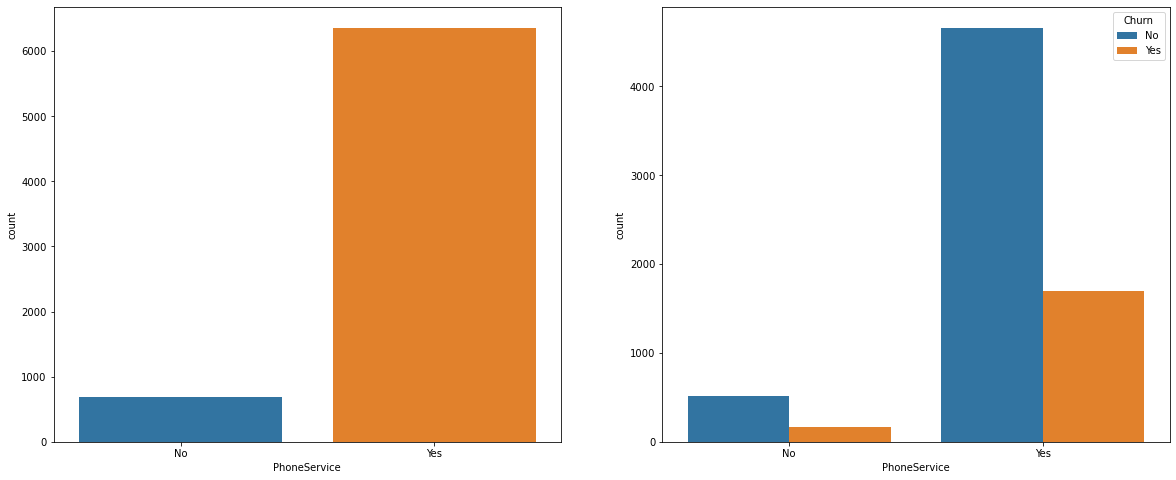

In [32]:
analyze('PhoneService')

In [33]:
raw_data.groupby('PhoneService')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

,tenure,MonthlyCharges,TotalCharges
PhoneService,,,
No,31.737537,42.028592,1496.033651
Yes,32.439082,67.199041,2363.759432


- `90.32%` người dùng dịch vụ cũng đăng kí PhoneService
- Dễ dàng thấy được trung bình thời gian ở lại dịch vụ là như nhau nhưng những người đăng kí PhoneService mang lại doanh thu cao hơn cho công ty so với những người không đăng kí

## `MultipleLines`

No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: MultipleLines, dtype: float64


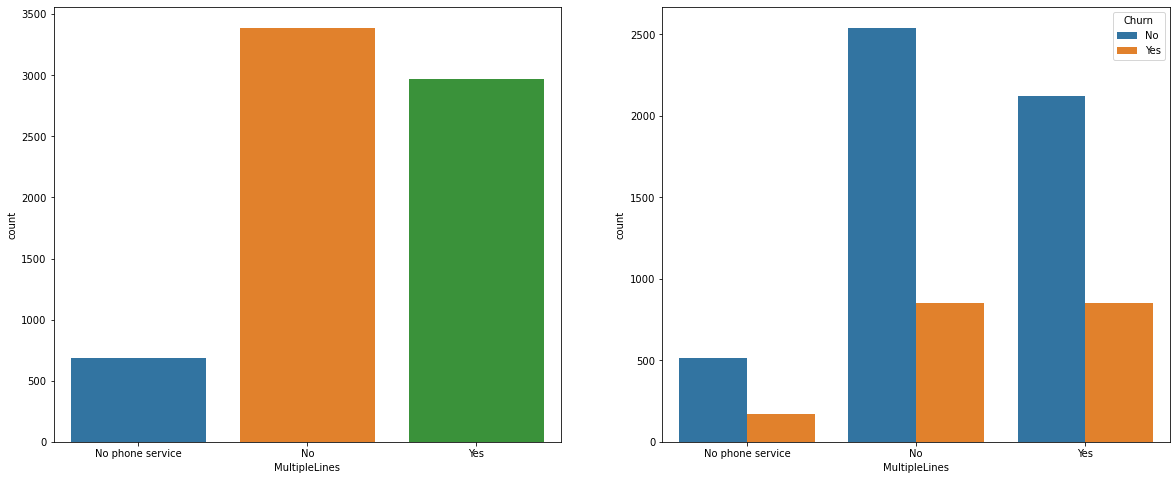

In [34]:
analyze('MultipleLines')

In [35]:
raw_data.groupby('MultipleLines')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

,tenure,MonthlyCharges,TotalCharges
MultipleLines,,,
No,24.134808,54.195059,1347.842153
No phone service,31.737537,42.028592,1496.033651
Yes,41.914507,82.036974,3522.951481


- `42.18%` người dùng đăng kí MultipleLines, `48.13%` không đăng kí `MultipleLines`, `9.69%` còn lại không đăng kí `PhoneService` nhưng tỉ lệ rời đi tháng sau của họ lại cao hơn (`28.61%` so với `25.04%`(không đăng kí `MultipleLines`) và `24.93%`(không đăng kí `PhoneService`))
- Doanh thu kiếm được từ những người đăng kí `MultipleLines` cũng cao hơn hẳn so với những người đăng kí 2 hình thức còn lại 
- Nhóm người đăng kí `MultipleLines` có xu hướng ở lại với công ty lâu hơn

## `InternetService`

Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: InternetService, dtype: float64

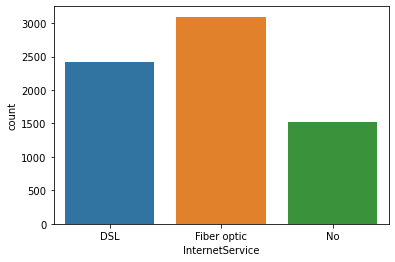

In [36]:
sns.countplot(x='InternetService', data=raw_data)

raw_data['InternetService'].value_counts(normalize=True)

Khoảng `21.67%` người dùng dịch vụ không đăng kí `InternetService`

In [37]:
pd.crosstab(raw_data['InternetService'], raw_data['PhoneService'])

PhoneService,No,Yes
InternetService,,
DSL,682,1739
Fiber optic,0,3096
No,0,1526


- Gói `Filber optic` chỉ dành cho những người đăng kí `PhoneService` nên có thể hiểu rằng đây là 1 gói cao cấp
- Gói `DSL` khả dụng cho cả 2 nhóm đăng kí `PhoneService` hoặc không

<AxesSubplot:xlabel='InternetService', ylabel='count'>

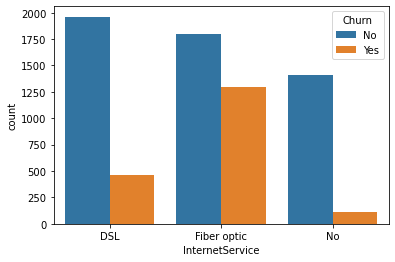

In [38]:
sns.countplot(x='InternetService', hue='Churn', data=raw_data)

In [39]:
print(raw_data.groupby('InternetService')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean())
print('=========================================================')
print(raw_data.groupby('InternetService')[['tenure', 'MonthlyCharges', 'TotalCharges']].sum())

                    tenure  MonthlyCharges  TotalCharges
InternetService                                         
DSL              32.821561       58.102169   2115.411338
Fiber optic      32.917959       91.500129   3205.304570
No               30.547182       21.079194    662.604784
                 tenure  MonthlyCharges  TotalCharges
InternetService                                      
DSL               79461       140665.35    5121410.85
Fiber optic      101914       283284.40    9923622.95
No                46615        32166.85    1011134.90


- Gói `Fiber optic` đem lại doanh thu cao nhất cho công ty vì có `43.96%` lượng người đăng kí và doanh thu thu được từ những người đăng kí gói này rất cao. Nhưng giá trị mà gói này mang lại cho người dùng chưa xứng đáng vì họ có tỉ lệ rời đi vào tháng sau rất lớn với `41.89%`
- Ngược lại, doanh thu thu được của công ty từ những người đăng kí gói `DSL` là thấp hơn nhiều nhưng những người dùng gói này khá hài lòng khi sử dụng gói vì tỉ lệ rời đi của họ thấp hơn rất nhiều với `18.96%`
- Khoảng `21.67%` người dùng không đăng kí InternetService và tỉ lệ rời đi vào tháng sau của họ cũng thấp nhất với `7.41%` nhưng doanh thu công ty thu được từ nhóm người này thấp hơn hẳn so với nhóm người đăng kí InternetService

## `OnlineSecurity`

No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: OnlineSecurity, dtype: float64


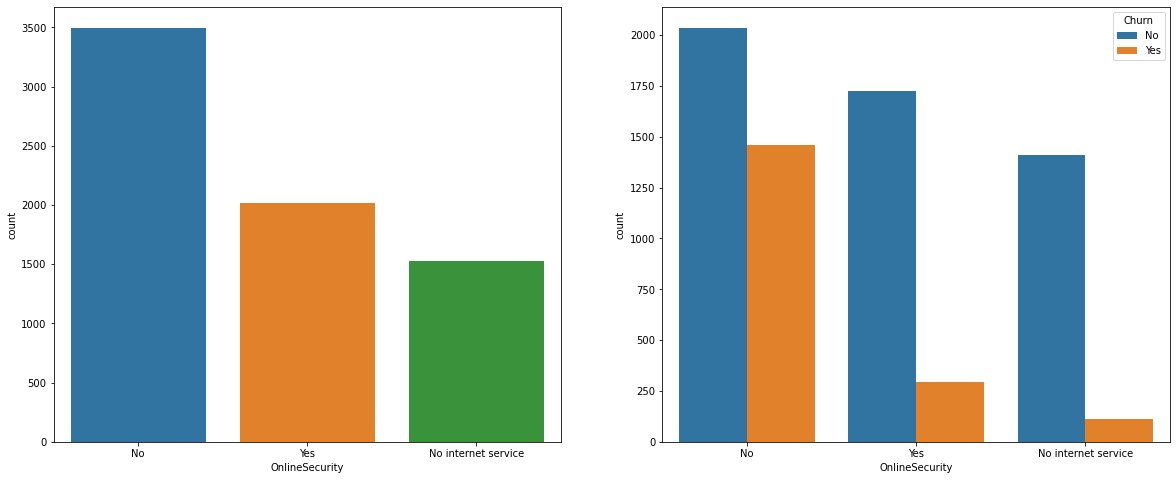

In [40]:
analyze('OnlineSecurity')

- `49.67%` người dùng không đăng kí `OnlineSecurity` và nhóm người này có tỉ lệ rời đi rất cao
- Nhóm người đăng kí `OnlineSecurity` khá hài lòng với chất lượng dịch vụ vì họ có tỉ lệ rời đi thấp hơn rất nhiều

## `OnlineBackup`

No                     0.438450
Yes                    0.344881
No internet service    0.216669
Name: OnlineBackup, dtype: float64


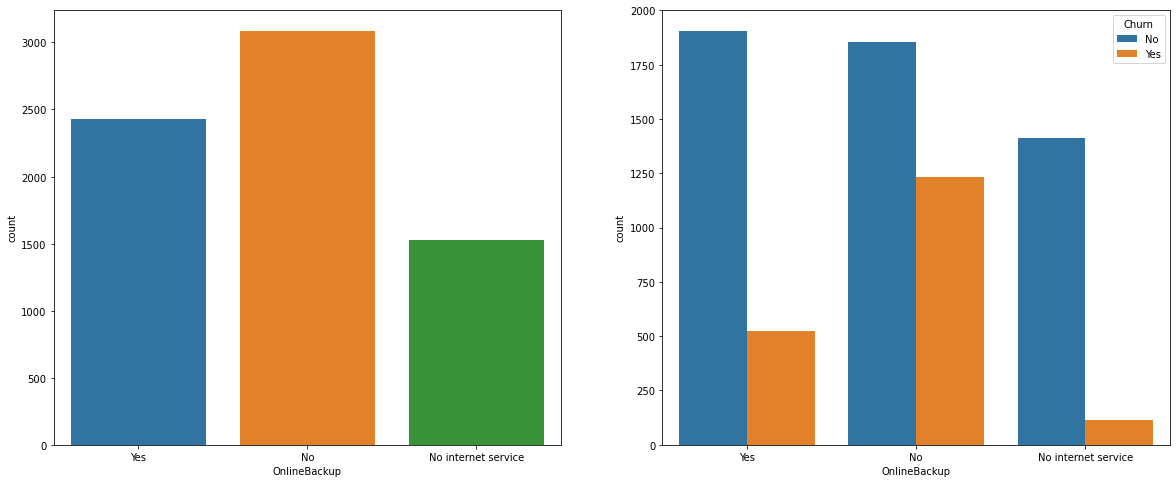

In [41]:
analyze('OnlineBackup')

Tương tự như nhóm người đăng kí `OnelineSecurity`, nhóm người không đăng kí `OnlineBackup` chiếm nhiều nhất với `43.85%` nhưng lại có tỉ lệ rời đi vào tháng sau cao hơn rất nhiều so với nhóm người có đăng kí `OnlineBackup`

## `DeviceProtection`

No                     0.439443
Yes                    0.343888
No internet service    0.216669
Name: DeviceProtection, dtype: float64


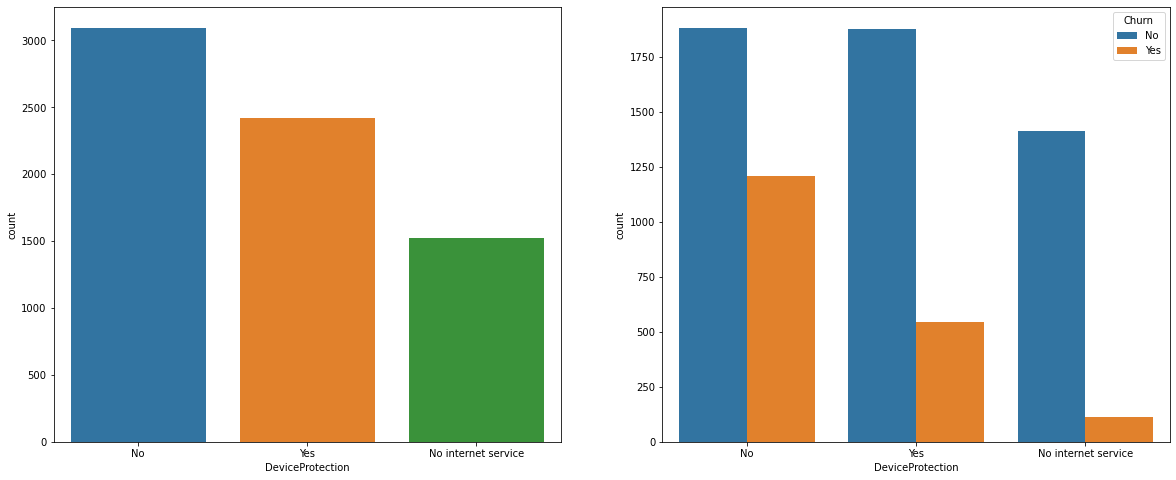

In [42]:
analyze('DeviceProtection')

Cũng tương tự như 2 nhóm trên, nhóm người không đăng kí `DeviceProtection` chiếm nhiều nhất với `43.94%` nhưng lại có tỉ lệ rời đi vào tháng sau cao hơn rất nhiều so với nhóm người có đăng kí `DeviceProtection`

## `TechSupport`

No                     0.493114
Yes                    0.290217
No internet service    0.216669
Name: TechSupport, dtype: float64


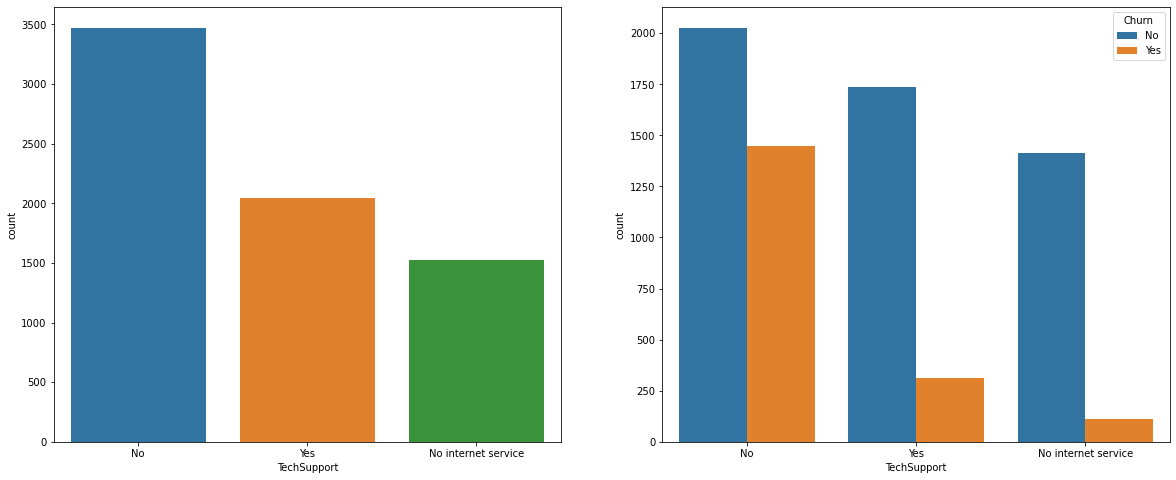

In [43]:
analyze('TechSupport')

Nhóm người không đăng kí `TechSupport` chiếm nhiều nhất với `49.31%` nhưng lại có tỉ lệ rời đi vào tháng sau cao hơn rất nhiều so với nhóm người có đăng kí `TechSupport`

## `StreamingTV`

No                     0.398978
Yes                    0.384353
No internet service    0.216669
Name: StreamingTV, dtype: float64


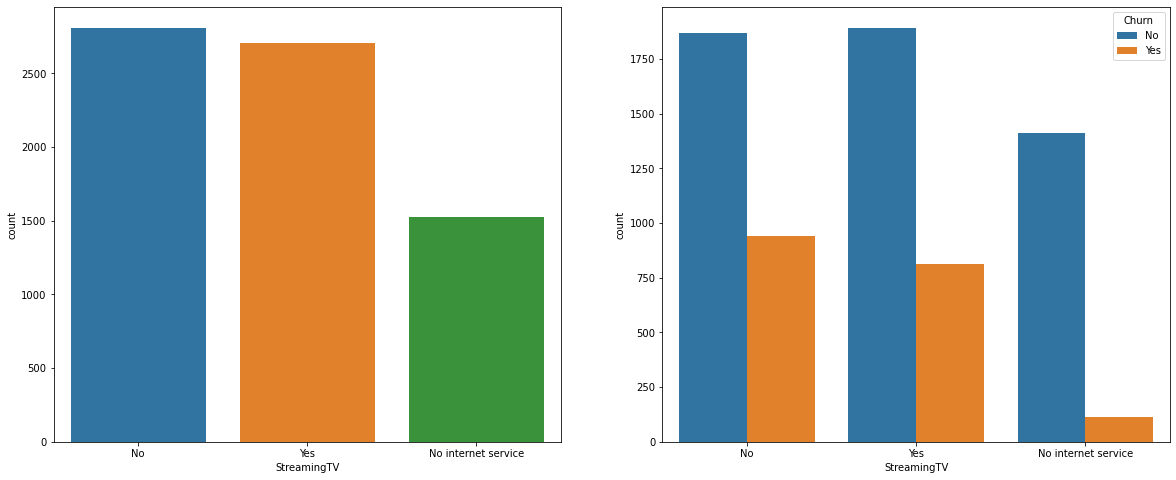

In [44]:
analyze('StreamingTV')

In [45]:
print(raw_data.groupby('StreamingTV')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean())
print('=============================================================')
print(raw_data.groupby('StreamingTV')[['tenure', 'MonthlyCharges', 'TotalCharges']].sum())

                        tenure  MonthlyCharges  TotalCharges
StreamingTV                                                 
No                   24.985409       65.387687   1734.790214
No internet service  30.547182       21.079194    662.604784
Yes                  41.066125       88.736738   3757.027447
                     tenure  MonthlyCharges  TotalCharges
StreamingTV                                              
No                    70209       183739.40     4874760.5
No internet service   46615        32166.85     1011134.9
Yes                  111166       240210.35    10170273.3


- Khác với những nhóm dịch vụ trên, lượng người dùng đăng kí `StreamingTV` là khá cao với `38.43%` nhưng cũng có tỉ lệ rời đi vào tháng sau khá cao
- Những người đăng kí `StreamingTV` có xu hướng ở lại lâu hơn

## `StreamingMovies`

No                     0.395428
Yes                    0.387903
No internet service    0.216669
Name: StreamingMovies, dtype: float64


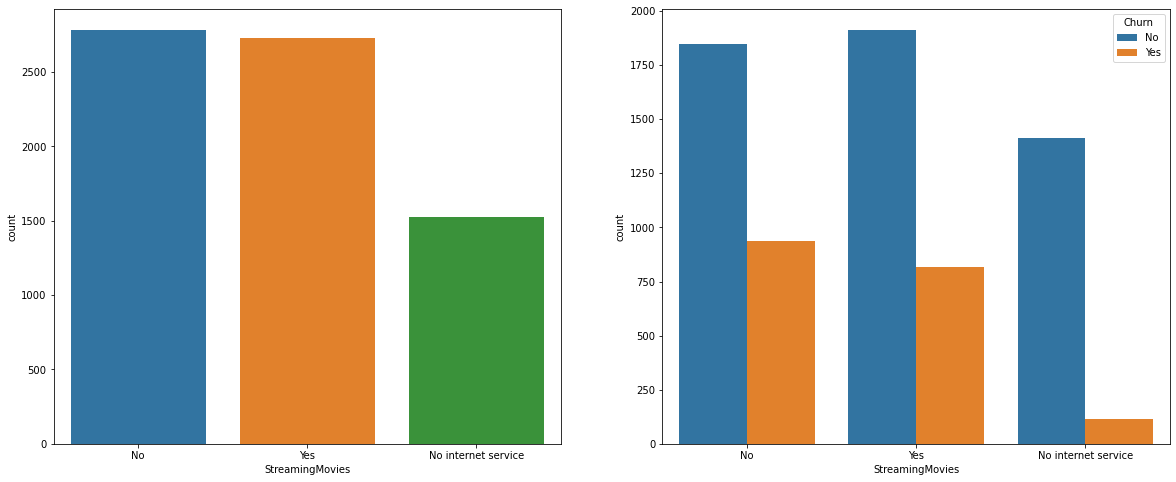

In [46]:
analyze('StreamingMovies')

In [47]:
print(raw_data.groupby('StreamingMovies')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean())
print('=============================================================')
print(raw_data.groupby('StreamingMovies')[['tenure', 'MonthlyCharges', 'TotalCharges']].sum())

                        tenure  MonthlyCharges  TotalCharges
StreamingMovies                                             
No                   24.712388       65.434147   1713.068007
No internet service  30.547182       21.079194    662.604784
Yes                  41.197291       88.475714   3760.665959
                     tenure  MonthlyCharges  TotalCharges
StreamingMovies                                          
No                    68824       182234.10     4770894.4
No internet service   46615        32166.85     1011134.9
Yes                  112551       241715.65    10274139.4


In [48]:
raw_data.groupby('StreamingTV')['StreamingMovies'].value_counts()

StreamingTV          StreamingMovies    
No                   No                     2018
                     Yes                     792
No internet service  No internet service    1526
Yes                  Yes                    1940
                     No                      767
Name: StreamingMovies, dtype: int64

- Tương tự với nhóm người dùng đăng kí `StreamingTV`, lượng người dùng đăng kí `StreamingMovies` là khá cao với `38.79%` nhưng cũng có tỉ lệ rời đi vào tháng sau khá cao
- Những người đăng kí `StreamingMovies` có xu hướng ở lại lâu hơn
- Người dùng có xu hướng đăng kí `StreamingTV` và `StreamingMovies` chung với nhau

## `Contract`

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: Contract, dtype: float64


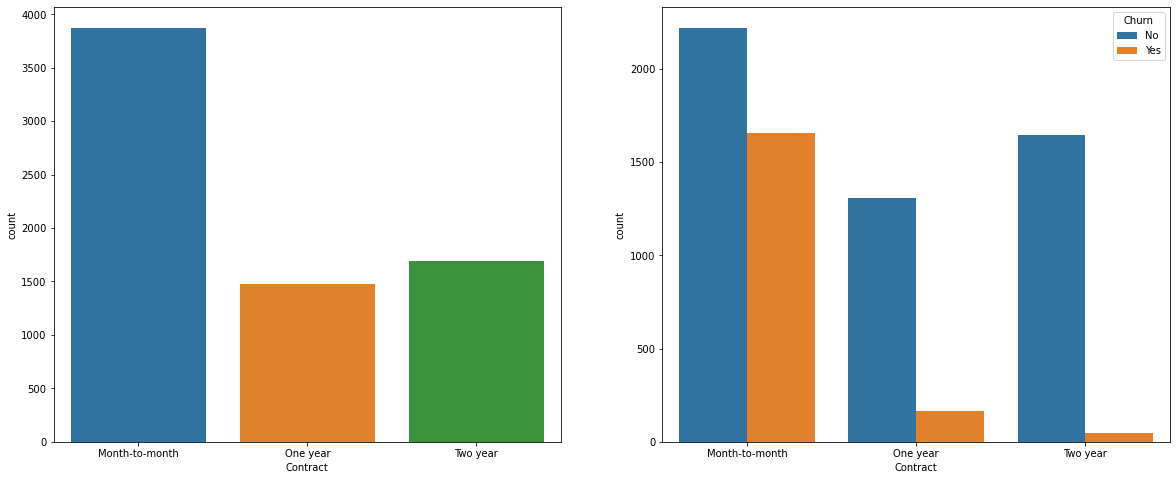

In [49]:
analyze('Contract')

- Dễ dàng thấy được nhóm người đăng kí `Contract` theo tháng chiếm nhiều nhất nhưng cũng là nhóm người dễ rời đi nhất
- Nhóm người đăng kí `Contract` 1 năm và 2 năm có tỷ lệ rời đi rất ý
- Khá ngạc nhiên là tỷ lệ người dùng đăng kí gói `Contract` 2 năm lại nhiều hơn gói 1 năm (`24.1%` vs `20.91%`)

## `PaperlessBilling`

Yes    0.592219
No     0.407781
Name: PaperlessBilling, dtype: float64


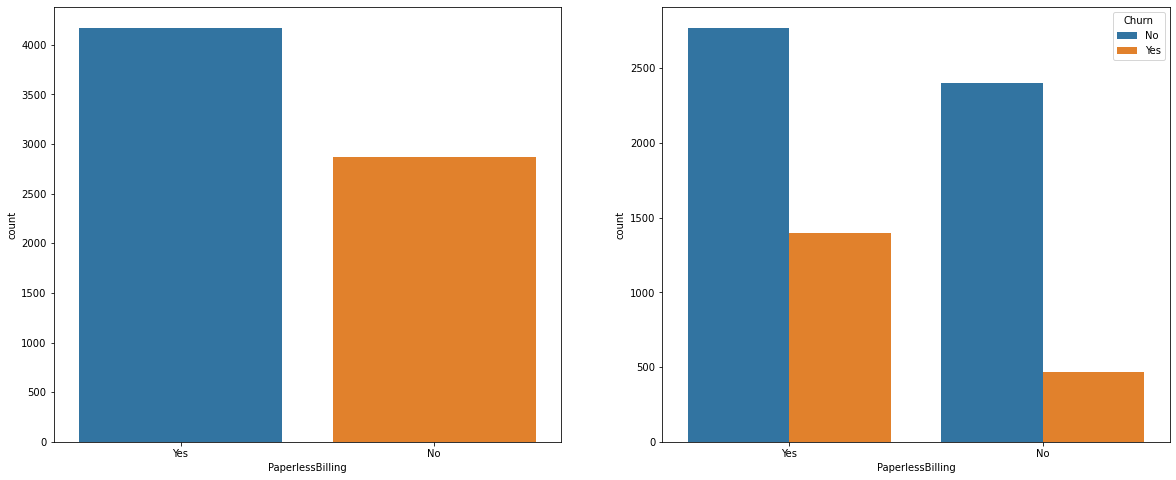

In [50]:
analyze('PaperlessBilling')

In [51]:
raw_data.groupby('PaperlessBilling')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

,tenure,MonthlyCharges,TotalCharges
PaperlessBilling,,,
No,32.189067,51.992967,1846.580449
Yes,32.496524,73.553776,2577.988408


- `59.22%` người dùng dịch vụ đăng kí `PaperlessBilling`
- Gói `PaperlessBilling` không mang lại nhiều giá trị cho người đăng kí vì họ có xu hướng rời đi vào tháng sau cao hơn
- Nhóm người đăng kí `PaperlessBilling` cũng không có xu hướng ở lại với công ty lâu hơn

## `PaymentMethod`

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: PaymentMethod, dtype: float64


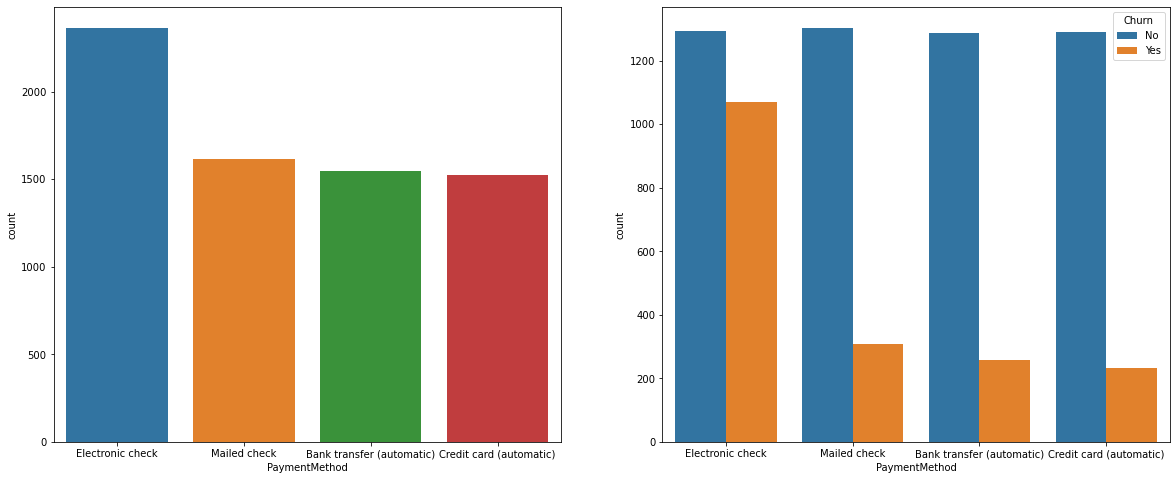

In [52]:
analyze('PaymentMethod')

In [53]:
raw_data.groupby('Churn')['PaymentMethod'].value_counts()

Churn  PaymentMethod            
No     Mailed check                 1304
       Electronic check             1294
       Credit card (automatic)      1290
       Bank transfer (automatic)    1286
Yes    Electronic check             1071
       Mailed check                  308
       Bank transfer (automatic)     258
       Credit card (automatic)       232
Name: PaymentMethod, dtype: int64

In [54]:
raw_data.groupby('PaymentMethod')[['tenure', 'MonthlyCharges', 'TotalCharges']].sum()

,tenure,MonthlyCharges,TotalCharges
PaymentMethod,,,
Bank transfer (automatic),67406,103745.45,4748279.90
Credit card (automatic),65856,101231.85,4671593.35
Electronic check,59538,180345.00,4944903.25
Mailed check,35190,70794.30,1691392.20


- `33.58%` người dùng đăng kí Electronic check, `22.89%` cho Mailed check, `21.92%` cho Bank transfer và `21.61%` cho Credit card
- Doanh thu từ gói `Electronic check` là cao nhất với lượng người dùng lớn
- Tỉ lệ rời đi của người dùng đăng kí gói `Electronic check` là cao nhất với `45.29%`
- 2 gói automatic là `Bank transfer` và `Credit card` có chất lượng dịch vụ hơn vì có người dùng có xu hướng ở lại với công ty lâu hơn
- Gói `Mailed check` mang lại thu nhập thấp nhất cho công ty cùng với xu hướng người dùng ở lại với công ty không lâu so với các gói còn lại

## `MonthlyCharges` & `TotalCharges`

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

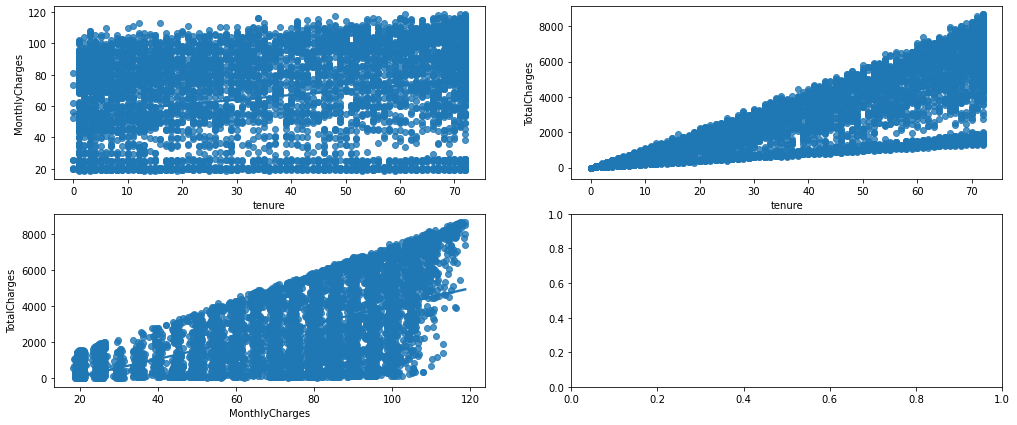

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(17,7))

sns.regplot(x='tenure', y='MonthlyCharges', data=raw_data, ax=ax[0,0])
sns.regplot(x='tenure', y='TotalCharges', data=raw_data, ax=ax[0,1])
sns.regplot(x='MonthlyCharges', y='TotalCharges', data=raw_data, ax=ax[1,0])

<AxesSubplot:>

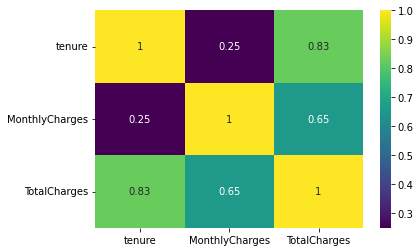

In [56]:
sns.heatmap(raw_data[['tenure', 'MonthlyCharges', 'TotalCharges']].corr(), annot=True, cmap='viridis')

<AxesSubplot:xlabel='TotalCharges', ylabel='Density'>

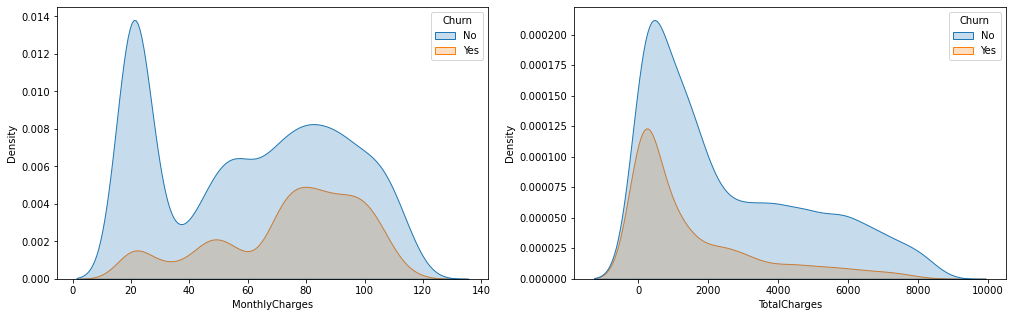

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(17,5))

sns.kdeplot(x='MonthlyCharges', hue='Churn', data=raw_data, shade=True, ax=ax[0])
sns.kdeplot(x='TotalCharges', hue='Churn', data=raw_data, shade=True, ax=ax[1])

- Có thể thấy được mối quan hệ giữa `tenure`, `MonthlyCharges`, `TotalCharges` là `linear` và có mối tương quan dương
- Mối tương quan giữa `tenure` và `TotalCharges` mạnh hơn giữa `tenure` và `MonthlyCharges` rất nhiều
- Những người có xu hướng rời đi cung cấp doanh thu cho công ty thấp hơn rất nhiều
- Có thể thấy được những trung bình số tiền chi tiêu của những người có xu hướng rời đi lại cao hơn những người có xu hướng ở lại với công ty

## `Num of Services`

In [58]:
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [59]:
# Bỏ `Contract` và `PaymentMethod`
temp_data = raw_data.copy()

temp_data['PhoneService'] = temp_data['PhoneService'].map({'Yes':1, 'No':0})
temp_data['MultipleLines'] = temp_data['MultipleLines'].map({'No phone service':0, 'No':0, 'Yes':1})
temp_data['InternetService'] = temp_data['InternetService'].map({'DSL':1, 'Fiber optic':1, 'No':0})
temp_data['OnlineSecurity'] = temp_data['OnlineSecurity'].map({'No':0, 'No internet service':0, 'Yes':1})
temp_data['OnlineBackup'] = temp_data['OnlineBackup'].map({'No':0, 'No internet service':0, 'Yes':1})
temp_data['DeviceProtection'] = temp_data['DeviceProtection'].map({'No':0, 'No internet service':0, 'Yes':1})
temp_data['TechSupport'] = temp_data['TechSupport'].map({'No':0, 'No internet service':0, 'Yes':1})
temp_data['StreamingTV'] = temp_data['StreamingTV'].map({'No':0, 'No internet service':0, 'Yes':1})
temp_data['StreamingMovies'] = temp_data['StreamingMovies'].map({'No':0, 'No internet service':0, 'Yes':1})
temp_data['PaperlessBilling'] = temp_data['PaperlessBilling'].map({'No':0, 'Yes':1})

In [60]:
temp_data['Num of Services'] = temp_data['PhoneService'] + temp_data['MultipleLines'] + temp_data['InternetService'] + temp_data['OnlineSecurity'] + temp_data['OnlineBackup'] + temp_data['DeviceProtection'] + temp_data['TechSupport'] + temp_data['StreamingTV'] + temp_data['StreamingTV'] + temp_data['PaperlessBilling']

<AxesSubplot:xlabel='Num of Services', ylabel='count'>

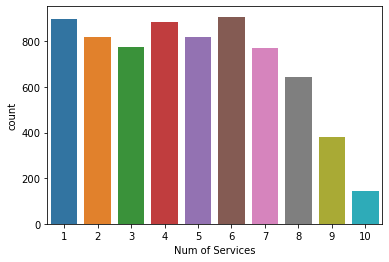

In [61]:
sns.countplot(x='Num of Services', data=temp_data)

<AxesSubplot:xlabel='Num of Services', ylabel='count'>

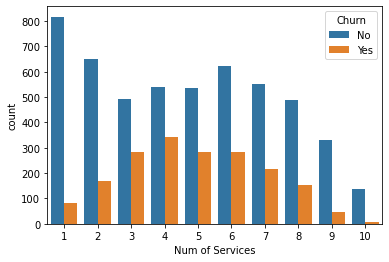

In [62]:
sns.countplot(x='Num of Services', hue='Churn', data=temp_data)

In [63]:
print(temp_data.groupby('Num of Services')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean())
print('==========================================================')
print(temp_data.groupby('Num of Services')[['tenure', 'MonthlyCharges', 'TotalCharges']].sum())

                    tenure  MonthlyCharges  TotalCharges
Num of Services                                         
1                25.057842       20.227586    502.416352
2                26.528049       30.340366    683.929268
3                18.972903       53.401935    838.780452
4                20.889140       64.774887   1320.470136
5                27.223443       72.096337   1915.641941
6                34.676211       80.818502   2743.675551
7                40.688312       87.733117   3544.881688
8                51.469673       94.916796   4883.492146
9                60.245383      100.337731   6047.262137
10               65.068493      105.214384   6880.815753
                 tenure  MonthlyCharges  TotalCharges
Num of Services                                      
1                 22527         18184.6     451672.30
2                 21753         24879.1     560822.00
3                 14704         41386.5     650054.85
4                 18466         57261.0    116

- Tỉ lệ người dùng đăng kí chỉ 1 dịch vụ là cao nhất, tỉ lệ người dùng đăng kí đầy đủ 10 dịch vụ là thấp nhất
- Dễ dàng thấy được những người có số lượng dịch vụ đăng kí nhiều hơn sẽ ở lại với công ty lâu hơn cùng với cung cấp doanh thu theo tháng bộ cho công ty nhiều hơn
- Tỉ lệ rời đi theo số lượng dịch vụ đăng kí lại là biểu đồ hình chuông: người dùng có tỉ lệ rời đi nhiều nhất lại ở khoảng 5-8 dịch vụ được đăng kí
- Ngược lại, những người đăng kí khoảng 1-2 hoặc 8-9 dịch vụ có tỉ lệ rời đi thấp so với nhóm người đăng kí từ 3-7 dịch vụ và nhóm người đăng kí đầy đủ 10 dịch vụ có tỉ lệ rời đi thấp nhất
- Có thể thấy được dù tỉ lệ người dùng đăng kí 10 dịch vụ là thấp nhất nhưng doanh thu thu được từ nhóm người này cao hơn nhóm người đăng kí từ 1-3 dịch vụ hàng tháng. Cùng với đó, mặc dù tỉ lệ người dùng đăng kí chỉ 1 dịch vụ là nhiều nhất nhưng doanh thu mà công ty kiếm được từ họ là thấp nhất
- Doanh thu của nhóm người đăng kí từ 6-9 dịch vụ là cao nhất

# Modeling

In [64]:
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [65]:
raw_data['Num of Services'] = temp_data['Num of Services']

Drop những feature không quan trọng

In [66]:
raw_data.drop(['customerID', 'gender'], axis=1, inplace=True)

Xử lý features

In [67]:
categorical_features = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Num of Services']

data = pd.get_dummies(raw_data, columns=categorical_features, drop_first=True)
data['Churn'] = data['Churn'].map({'No':0, 'Yes':1})

In [68]:
X = data.drop('Churn', axis=1)
y = data['Churn']

X.shape, y.shape

((7043, 30), (7043,))

##### Huấn luyện model với data thông thường

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1713)

scaler = MinMaxScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

##### LogisticRegression

In [70]:
logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000)
logistic_model.fit(X_train, y_train)

logistic_y_pred = logistic_model.predict(X_test)
print(classification_report(logistic_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1106
           1       0.52      0.64      0.58       303

    accuracy                           0.80      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.82      0.80      0.80      1409



##### RandomForestClassifier

In [71]:
rfc_model = RandomForestClassifier(n_estimators=600)
rfc_model.fit(X_train, y_train)

rfc_y_pred = rfc_model.predict(X_test)
print(classification_report(rfc_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1102
           1       0.49      0.60      0.54       307

    accuracy                           0.78      1409
   macro avg       0.69      0.72      0.70      1409
weighted avg       0.80      0.78      0.79      1409



##### GradientBoostingClassifier

In [72]:
gbc_model = GradientBoostingClassifier(n_estimators=600, learning_rate=0.01, random_state=1713)
gbc_model.fit(X_train, y_train)

gbc_y_pred = gbc_model.predict(X_test)
print(classification_report(gbc_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1132
           1       0.48      0.65      0.56       277

    accuracy                           0.79      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.82      0.79      0.81      1409



## Xử lý dữ liệu không cân bằng

In [73]:
data['Churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

Dữ liệu bị mất cân bằng nhẹ với `73.46%` thuộc về class Non-Churn và `26.54%` thuộc về class còn lại

### Under_sampling - NearMiss

In [74]:
nm = NearMiss()

X_nm, y_nm = nm.fit_resample(X, y)
X_nm.shape, y_nm.shape

((3738, 30), (3738,))

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_nm, y_nm, test_size=0.2, random_state=1713)

scaler = MinMaxScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

X_train.shape, X_test.shape

((2990, 30), (748, 30))

##### LogisticRegression

In [76]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

logistic_y_pred = logistic_model.predict(X_test)
print(classification_report(logistic_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63       319
           1       0.73      0.66      0.70       429

    accuracy                           0.67       748
   macro avg       0.66      0.67      0.66       748
weighted avg       0.67      0.67      0.67       748



##### RandomForestClassifier

In [77]:
rfc_model = RandomForestClassifier(n_estimators=600)
rfc_model.fit(X_train, y_train)

rfc_y_pred = rfc_model.predict(X_test)
print(classification_report(rfc_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.62      0.63      0.62       356
           1       0.66      0.66      0.66       392

    accuracy                           0.64       748
   macro avg       0.64      0.64      0.64       748
weighted avg       0.64      0.64      0.64       748



##### GradientBoostingClassifier

In [78]:
gbc_model = GradientBoostingClassifier(n_estimators=600, learning_rate=0.01, random_state=1713)
gbc_model.fit(X_train, y_train)

gbc_y_pred = gbc_model.predict(X_test)
print(classification_report(gbc_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       337
           1       0.72      0.68      0.70       411

    accuracy                           0.68       748
   macro avg       0.68      0.68      0.68       748
weighted avg       0.68      0.68      0.68       748



### Over_sampling

#### SMOTE

In [79]:
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)
X_smote.shape, y_smote.shape

((10348, 30), (10348,))

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=1713)

scaler = MinMaxScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

X_train.shape, X_test.shape

((8278, 30), (2070, 30))

##### LogisticRegression

In [81]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

logistic_y_pred = logistic_model.predict(X_test)
print(classification_report(logistic_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       979
           1       0.86      0.84      0.85      1091

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



D:\STUDY AI\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### RandomForestClassifier

In [82]:
rfc_model = RandomForestClassifier(n_estimators=600)
rfc_model.fit(X_train, y_train)

rfc_y_pred = rfc_model.predict(X_test)
print(classification_report(rfc_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       996
           1       0.84      0.84      0.84      1074

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



##### GradientBoostingClassifier

In [83]:
gbc_model = GradientBoostingClassifier(n_estimators=600, learning_rate=0.01, random_state=1713)
gbc_model.fit(X_train, y_train)

gbc_y_pred = gbc_model.predict(X_test)
print(classification_report(gbc_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       931
           1       0.86      0.81      0.83      1139

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.83      0.82      0.82      2070



#### RandomOverSampler

In [84]:
ros = RandomOverSampler()

X_ros, y_ros = ros.fit_resample(X, y)
X_ros.shape, y_ros.shape

((10348, 30), (10348,))

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=1713)

scaler = MinMaxScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

X_train.shape, X_test.shape

((8278, 30), (2070, 30))

##### LogisticRegression

In [86]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

logistic_y_pred = logistic_model.predict(X_test)
print(classification_report(logistic_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       922
           1       0.82      0.76      0.79      1148

    accuracy                           0.77      2070
   macro avg       0.77      0.78      0.77      2070
weighted avg       0.78      0.77      0.78      2070



D:\STUDY AI\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### RandomForestClassifier

In [87]:
rfc_model = RandomForestClassifier(n_estimators=600)
rfc_model.fit(X_train, y_train)

rfc_y_pred = rfc_model.predict(X_test)
print(classification_report(rfc_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       879
           1       0.96      0.86      0.91      1191

    accuracy                           0.90      2070
   macro avg       0.90      0.91      0.90      2070
weighted avg       0.91      0.90      0.90      2070



##### GradientBoostingClassifier

In [88]:
gbc_model = GradientBoostingClassifier(n_estimators=600, learning_rate=0.01, random_state=1713)
gbc_model.fit(X_train, y_train)

gbc_y_pred = gbc_model.predict(X_test)
print(classification_report(gbc_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.74      0.82      0.77       906
           1       0.84      0.77      0.81      1164

    accuracy                           0.79      2070
   macro avg       0.79      0.79      0.79      2070
weighted avg       0.80      0.79      0.79      2070

